In [26]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.linalg import eigvals

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, palette='Set2')
sns.set_style('darkgrid')

In [27]:
a=np.eye(3)
np.linalg.det(a)

1.0

__________________
## Задача 1.

По шаблону напишите класс, реализующий линейную регрессию. Интерфейс этого класса в некоторой степени соответствует классу <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`LinearRegression`</a> из библиотеки `sklearn`.

In [28]:
class LinearRegression:
    '''
    Класс, реализующий линейную регрессию c помощью МНК.
    '''
    
    def __init__(self, fit_intercept=True, alpha=0.05):
        '''   
        :param fit_intercept: добавлять ли смещение(константный признак)
        :param alpha: уровень значимости критерия, 
                      (1-alpha): уровень доверия дов. интервала
        '''
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        
    def fit(self, X, Y):
        '''
        Функция обучения модели. 
        
        Предполагается модель Y = X * theta + epsilon, 
        где epsilon имеет норм. распр. с параметрами (0, sigma^2 * I_n).
        
        :param X: регрессор (матрица размера n x d), 
        :param Y: отклик (матрица размера n x 1),
        '''
        
        # При необходимости добавим константу
        if self.fit_intercept:
            X_with_constant = np.hstack((np.ones((X.shape[0], 1)), X))
            X = X_with_constant
                
        # размерности матрицы X
        self.n, self.d = X.shape
        # МНК-оценка
        self.x_transpose_x = np.matrix(X.T @ X)
        self.theta = np.array(self.x_transpose_x.I) @ X.T @ Y
        # несмещенная оценка для sigma^2
        self.sigma_sq = ((Y - X @ self.theta) ** 2).sum() \
                        / (self.n - self.d)
        # вспомогательные величины для подсчетов
        root = np.sqrt(np.diag(np.array(np.matrix(X.T @ X).I)) \
                       * self.sigma_sq)
        quantile = sps.t(df=self.n-self.d).ppf(1 - self.alpha/ 2)
        # доверительные интервалы для коэффициентов
        self.conf_int = np.vstack(([self.theta - root * quantile, 
                                    self.theta + root * quantile])).T
        # статистики критериев о незначимости коэффициентов
        self.t_stats = self.theta / root
        # p-value критериев о незначимости коэффициентов
        self.pvalue = 2*sps.t(df=self.n-self.d).sf(np.abs(self.t_stats))
        
        return self
    
    def summary(self):
        '''
        Печатает таблицу с информацией для каждого коэффициента,
        в которой указана его оценка, границы дов. интервала,
        статистика критерия и значение p-value
        '''
        
        print(f'Линейная регрессия на {self.d} признаках и {self.n} объектах')
        print(f'Sigma: {self.sigma_sq:.6f}')
        
        # Далее напечатайте таблицу, 
        # в которой для каждого коэффициента (по строкам)
        # будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца), 
        # статистика критерия, p-value
        print('\t\tЛевая граница\tОценка\t\tВерхняя граница\t' \
              'T-stat\t\tp-value')
        for j in range(self.d):
            print('theta_%d:\t%.6f\t%.6f\t%.6f\t%.6f\t%.6f' \
                  % (j, self.conf_int[j, 0], 
                     self.theta[j], self.conf_int[j, 1], 
                     self.t_stats[j], self.pvalue[j]))
        
    def predict(self, X, type_interval=None):
        '''
        Возвращает предсказание отклика на новых объектах X 
        и опционально доверительный/предсказательный интервал.
        
        :param X: матрица объектов размера n x d
        :param type_interval: тип дов. интервала. 
                        Для этого параметра возможны три варианта:
                        * None - возвратить только предсказание, 
                                размер return-a: n;
                        * 'confidence' - возвратить предсказание и 
                            доверительный интервал для среднего отклика, 
                            размер return-a: n x 3;
                        * 'prediction' - возвратить предсказание и 
                            предсказательный интервал для новых объектов, 
                            размер return-a: n x 3.
                              
        :return y_pred: предсказание/предсказание и дов./предсказ. инт.
                        
        '''
        X = np.asarray(X)
        # при необходимости добавим контсанту
        if self.fit_intercept:
            X_with_constant = np.hstack((np.ones((X.shape[0], 1)), X))
            X = X_with_constant
        # получим предсказание        
        y_pred = X @ self.theta
        
        if type_interval is None:
            return y_pred
        else :
            # квантиль распр. Стьюдента
            quantile = sps.t(df=self.n-self.d).ppf(1 - self.alpha/ 2)
            # добавляем 1, если это предсказательный интервал
            pred_addition = int(type_interval == 'prediction')
            # подсчет выражения под корнем
            root = np.sqrt(
                (pred_addition + np.diag(X @ self.x_transpose_x.I @ X.T)) \
                * self.sigma_sq
            )
            # строим интервал
            left = y_pred - quantile * root
            right = y_pred + quantile * root
            interval = (left, right)
            return y_pred, interval

Загрузите данные о потреблении мороженного в зависимости от температуры воздуха и цены (файл `ice_cream.txt`).
Примените реализованный выше класс линейной регрессии к этим данным предполагая, что модель имеет вид $ic = \theta_1 + \theta_2\ t$, где $t$ — температура воздуха (столбец `temp`), $ic$ — потребление мороженного в литрах на человека (столбец `IC`).
Значения температуры предварительно переведите из Фаренгейта в Цельсий. Преобразование температуры по шкале Фаренгейта в температуру по шкале Цельсия: $t_C = \frac{(t_F - 32)}{1,8}$ 

К обученной модели примените фунцию `summary` и постройте график регрессии, то есть график прямой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t$, где $\widehat{\theta}_1, \widehat{\theta}_2$ — МНК-оценки коэффициентов.
На график нанесите точки выборки. Постройте также доверительный интервал для среднего отклика и предсказательный интервал. В чем их различие? Проанализируйте результаты.

In [29]:
data = pd.read_csv('ice_cream.txt', sep='\t')  # загрузим данные
data.head(3)

,date,IC,price,income,temp,Lag-temp,Year
0,1,0.386,0.270,78,41,56,0
1,2,0.374,0.282,79,56,63,0
2,3,0.393,0.277,81,63,68,0


In [30]:
# отклик
Y = data['IC']
# регрессор
X = (data['temp'].values - 32) / 1.8  # значение температуры в цельсиях

In [31]:
lr = LinearRegression().fit(X[:, np.newaxis], Y)
lr.summary()

Линейная регрессия на 2 признаках и 30 объектах
Sigma: 0.001786
		Левая граница	Оценка		Верхняя граница	T-stat		p-value
theta_0:	0.283276	0.306298	0.329319	27.253231	0.000000
theta_1:	0.003831	0.005593	0.007355	6.502305	0.000000


Гипотезы о незначимости отвергаются. Построим график для регрессии.

In [32]:
temp_grid = np.linspace(-10, 30, 200)  # сетка для температуры
# получим предсказание и дов./предсказ. интервалы
predictions, conf_int = lr.predict(temp_grid[:, np.newaxis], 
                                   type_interval='confidence')
_, pred_int = lr.predict(temp_grid[:, np.newaxis], 
                         type_interval='prediction')

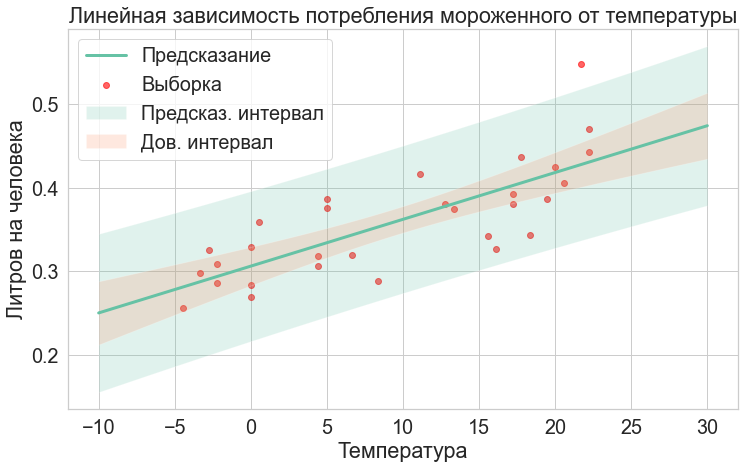

In [8]:
plt.figure(figsize=(12, 7))
sns.set_style('whitegrid')

plt.scatter(X, Y, alpha=0.6, color='red', label='Выборка')
plt.plot(temp_grid, predictions, 
         lw=3, label='Предсказание')

plt.fill_between(temp_grid, pred_int[0], pred_int[1], 
                 label="Предсказ. интервал", alpha=0.2)
plt.fill_between(temp_grid, conf_int[0], conf_int[1], 
                 label="Дов. интервал", alpha=0.2)

plt.legend()
plt.xlabel('Температура')
plt.ylabel('Литров на человека')
plt.title('Линейная зависимость потребления мороженного от температуры')
plt.show()

**Выводы:** 
* Предсказательный интервал для **наблюдаемого отклика** для нового объекта  учитывает ошибку $\varepsilon$, поэтому оказывается шире доверительного интервала. 
* Можно заметить, что почти все объекты исходной выборки попали в предсказательный интервал. 
* Хорошо видно, что при такой модели с ростом тепературы растет потребление мороженного.

Теперь учтите влияние года (столбец `Year`) для двух случаев.
* Модель $ic = \theta_1 + \theta_2\ t + \theta_3 y_1 + \theta_4 y_2$, где $y_1 = I\{1\ год\}, y_2 = I\{2\ год\}$. Поясните, почему нельзя рассмативать одну переменную $y$ — номер года.
* Для каждого года рассматривается своя линейная зависимость $ic = \theta_1 + \theta_2\ t$.

В каждом случае нарисуйте графики. Отличаются ли полученные результаты? Почему? От чего это зависит? Как зависит потребление мороженного от года? 

**Первая модель:**  $ic = \theta_1 + \theta_2\ t + \theta_3 y_1 + \theta_4 y_2$, где $y_1 = I\{1\ год\}, y_2 = I\{2\ год\}$

В условии задачи не преполагается линейная зависимость потребления мороженного от года, поэтому нельзя использовать одну переменную $y$ &mdash; номер года.

In [9]:
# отклик
Y = data['IC'].values
# регрессор
X = np.zeros((len(data), 4))
X[:, 0] = 1  # контсантный признак
X[:, 1] = (data['temp'].values - 32) / 1.8  # значение температуры в цельсиях
# учтем год
X[:, 2] = data['Year'].values == 1
X[:, 3] = data['Year'].values == 2

lr = LinearRegression(fit_intercept=False).fit(X, Y)
lr.summary()

Линейная регрессия на 4 признаках и 30 объектах
Sigma: 0.001016
		Левая граница	Оценка		Верхняя граница	T-stat		p-value
theta_0:	0.251176	0.277050	0.302923	22.010266	0.000000
theta_1:	0.004741	0.006095	0.007449	9.251310	0.000000
theta_2:	-0.011237	0.016491	0.044218	1.222508	0.232483
theta_3:	0.041535	0.074307	0.107078	4.660736	0.000082


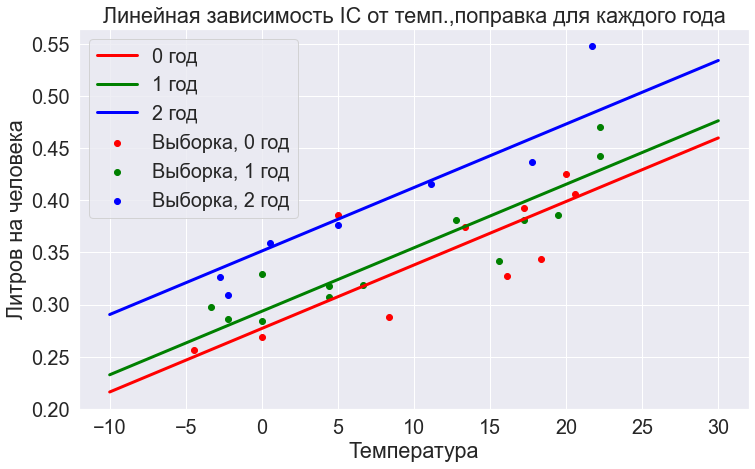

In [10]:
plt.figure(figsize=(12, 7))
sns.set_style('darkgrid')

for i, color in zip(range(3), ['r', 'g', 'b']):
    plt.scatter(X[:, 1][data['Year'].values == i], Y[data['Year'].values == i], 
                color=color, label=f'Выборка, {i} год')
    plt.plot([-10, 30], lr.predict([[1, -10, i==1, i==2], 
                                    [1, 30, i==1, i==2]]), 
             lw=3, color=color, label=f'{i} год')
plt.legend()
plt.xlabel('Температура')
plt.ylabel('Литров на человека')
plt.title(
    'Линейная зависимость IC от темп.,поправка для каждого года')
plt.show()

**Вторая модель:** для каждого года рассматривается своя линейная зависимость $ic = \theta_1 + \theta_2\ t$.


0 год:
Линейная регрессия на 2 признаках и 10 объектах
Sigma: 0.001597
		Левая граница	Оценка		Верхняя граница	T-stat		p-value
theta_0:	0.236963	0.286405	0.335846	13.358176	0.000001
theta_1:	0.001787	0.005277	0.008767	3.486794	0.008237

1 год:
Линейная регрессия на 2 признаках и 13 объектах
Sigma: 0.000667
		Левая граница	Оценка		Верхняя граница	T-stat		p-value
theta_0:	0.274993	0.297426	0.319859	29.181668	0.000000
theta_1:	0.003935	0.005672	0.007409	7.185698	0.000018

2 год:
Линейная регрессия на 2 признаках и 7 объектах
Sigma: 0.000766
		Левая граница	Оценка		Верхняя граница	T-stat		p-value
theta_0:	0.303805	0.338346	0.372886	25.180180	0.000002
theta_1:	0.004907	0.007877	0.010846	6.817778	0.001035


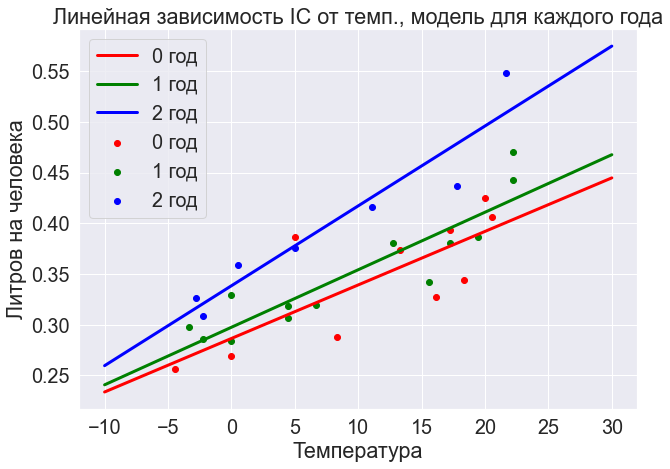

In [11]:
plt.figure(figsize=(10, 7))

for i, color in zip(range(3), ['r', 'g', 'b']):
    # регрессор для текущего года
    X = np.zeros((np.sum(data['Year'].values == i), 2))
    X[:, 0] = 1
    X[:, 1] = (data['temp'].values[data['Year'].values == i] - 32) / 1.8
    # отклик для текущего года
    Y = data['IC'].values[data['Year'].values == i]
    
    lr = LinearRegression(fit_intercept=False).fit(X, Y)
    print('\n%d год:'%i)
    lr.summary()
    
    # график для текущего года
    plt.scatter(X[:, 1], Y, color=color, label='%d год'%i)
    plt.plot([-10, 30], lr.predict([[1, -10], [1, 30]]), 
             lw=3, color=color, label='%d год'%i)
    
plt.legend()

plt.xlabel('Температура')
plt.ylabel('Литров на человека')
plt.title(
    'Линейная зависимость IC от темп., модель для каждого года'
)
plt.show()

**Вывод:** Результаты в двух рассмотренных случаях отличаются, это видно по графикам. Причина отличия &mdash; различный подход: 

* в первом случае предполагается, от года зависит только свободный коэффициент, в то время как коэффициент перед значением температуры от года не зависит, в таком случае для каждого года у нас имеется параллельный перенос; 

* во втором случае и коэффициент при температуре и свободный коэффициент зависят от конкретного года (на графике коэффициент при температуре связан с углом наклона прямой). 

Наконец, обучите модель на предсказание потребления мороженного в зависимости от всех признаков, кроме `Lag-Temp`.
Не забудьте, что для года нужно ввести две переменных.
Для полученной модели выведите `summary`.

In [23]:
data.iloc[:, :].head()

,date,IC,price,income,temp,Lag-temp,Year
0,1,0.386,0.270,78,41,56,0
1,2,0.374,0.282,79,56,63,0
2,3,0.393,0.277,81,63,68,0
3,4,0.425,0.280,80,68,69,0
4,5,0.406,0.272,76,69,65,0


In [25]:
# отклик
Y = data['IC']
# регрессор
X = np.zeros((len(data), 7))
X[:, 0] = 1   # константный признак
# все признаки кроме Lag-Temp и date
X[:, 1:5] = data.iloc[:, [2,3,4,6]]
X[:, 3] = (X[:, 3] - 32) / 1.8  # температура в цельсиях
# учтем год
X[:, 5] = data['Year'] == 1
X[:, 6] = data['Year'] == 2

lr = LinearRegression(fit_intercept=False).fit(X, Y)
lr.summary()

Линейная регрессия на 7 признаках и 30 объектах
Sigma: 2.709607
		Левая граница	Оценка		Верхняя граница	T-stat		p-value
theta_0:	-45.084849	-14.066047	16.952755	-0.938071	0.357955
theta_1:	0.237605	90.568867	180.900129	2.074099	0.049449
theta_2:	-0.350124	-0.116462	0.117200	-1.031061	0.313233
theta_3:	-0.093972	-0.017307	0.059357	-0.467011	0.644886
theta_4:	nan	7.566966	nan	nan	nan
theta_5:	nan	-6.822029	nan	nan	nan
theta_6:	nan	-14.144730	nan	nan	nan


C:\Users\Vova\AppData\Local\Temp/ipykernel_13248/1992807353.py:40: RuntimeWarning: invalid value encountered in sqrt
  root = np.sqrt(np.diag(np.array(np.matrix(X.T @ X).I)) \


Заметьте, что мы не учитывали признак `date`. Видим, что гипотезы о незначимости не отклоняются для некоторых признаков.

Но это еще не все.
Постройте теперь линейную регрессию для модели $ic = \theta_1 + \theta_2\ t + \theta_3\ t^2 + \theta_4\ t^3$.
Выведите для нее summary и постройте график предсказания, то есть график кривой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t + \widehat{\theta}_3\ t^2 + \widehat{\theta}_4\ t^3$. Хорошие ли получаются результаты?

In [13]:
# отклик
Y = data['IC']
# регрессор
X = np.zeros((len(data), 4))
X[:, 0] = 1  # константа
X[:, 1] = (data.iloc[:, 4] - 32) / 1.8  #температура
X[:, 2] = X[:, 1] ** 2  # температура^2
X[:, 3] = X[:, 1] ** 3  # температура^3

lr = LinearRegression(fit_intercept=False).fit(X, Y)
lr.summary()

Линейная регрессия на 4 признаках и 30 объектах
Sigma: 0.001529
		Левая граница	Оценка		Верхняя граница	T-stat		p-value
theta_0:	0.295294	0.319902	0.344510	26.721959	0.000000
theta_1:	0.000388	0.007200	0.014013	2.172538	0.039118
theta_2:	-0.001861	-0.000855	0.000152	-1.745679	0.092675
theta_3:	0.000002	0.000038	0.000073	2.180118	0.038492


Отобразим исходные данные и предсказания на графике.

In [14]:
grid = np.linspace(-10, 30, 1000)  # сетка
new_X = np.zeros((len(grid), 4))  # регрессор 
new_X[:, 0] = 1  # контстанта
new_X[:, 1] = grid  # температура
new_X[:, 2] = grid ** 2  # температура^2
new_X[:, 3] = grid ** 3  # температура^3

# получим предсказания модели
y_pred = lr.predict(new_X)

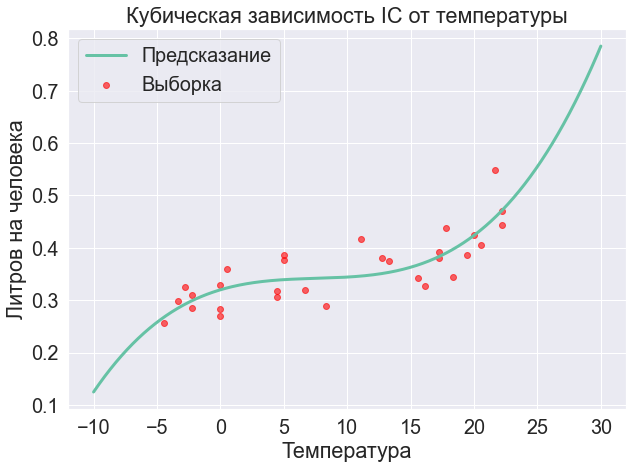

In [15]:
plt.figure(figsize=(10, 7))

plt.scatter(X[:, 1], Y, alpha=0.6, color='red', label='Выборка')
plt.plot(grid, y_pred, lw=3, label='Предсказание')

plt.legend()
plt.xlabel('Температура')
plt.ylabel('Литров на человека')
plt.title(
    'Кубическая зависимость IC от температуры'
)
plt.show()

**Вывод:** Визуально кажется, что модель излишне подстраивается под данные и возможно будет плохо подходить для данных не участвавших в обучении, то есть происходит переобучение модели.

Чтобы понять, почему так происходит, выведите значения матрицы $(X^T X)^{-1}$ для данной матрицы и посчитайте для нее индекс обусловленности $\sqrt{\left.\lambda_{max}\right/\lambda_{min}}$, где $\lambda_{max}, \lambda_{min}$ — максимальный и минимальный собственные значения матрицы $X^T X$. Собственные значения можно посчитать функцией <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigvals.html">`scipy.linalg.eigvals`</a>.

Прокомментируйте полученные результаты. Помочь в этом может следующая <a href="https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%BE_%D0%BE%D0%B1%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8">статья</a>.

Посмотрим на саму матрицу.

In [16]:
(np.matrix(X.T @ X).I)

matrix([[ 9.37480084e-02,  3.89861423e-03, -1.78656900e-03,
          6.69029822e-05],
        [ 3.89861423e-03,  7.18536599e-03, -8.80905447e-04,
          2.52158328e-05],
        [-1.78656900e-03, -8.80905447e-04,  1.56779604e-04,
         -5.35416603e-06],
        [ 6.69029822e-05,  2.52158328e-05, -5.35416603e-06,
          1.95858936e-07]])

Вычислим собственные значения и индекс обусловленности.

In [16]:
ev = eigvals(X.T @ X)
CI = np.sqrt(ev.max() / ev.min())
CI

(8140.394748901587+0j)

* Индекс обусловленности матрицы довольно велик (как барьер можно использовать число 30, после которого стоит считать, что данные участвующие в обучении модели мультиколлинеарны (то есть присутствуют линейные зависимости между различными признаками)), что приводит к **неустойчивости оценок и увеличению их дисперсии**; 

* Индекс обусловленности определяет насколько велика погрешность решения уравнения $Y = X\theta$, то есть $RSS = \|Y - X\widehat{\theta}\|^2$, который задает несмещенную оценку $\sigma^2$ &mdash; $ \widehat{\sigma}^2 = \frac{1}{n-d}RSS$, именна она в свою очередь отвечает за ширину доверительного интервала оценки параметра $\theta$.